In [1]:
import os
os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=10'

import numpy as np
import jax
import jax.numpy as jnp
import jax.random as jr
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'times'
import sympy as sp
import re

from kozax.genetic_programming import GeneticProgramming
import diffrax

from evaluators.lqg import LQG
from evaluators.dynamic_evaluate import DynamicEvaluator
from evaluators.static_evaluate import StaticEvaluator
from evaluators.nde import NDE_Evaluator
from evaluators.lagged_evaluator import LaggedEvaluator

from environments.harmonic_oscillator import HarmonicOscillator
from environments.reactor import StirredTankReactor
from environments.acrobot import Acrobot, Acrobot2

colormap = cm.Set3
color_dict = {"NODE":cm.Set1(0.3), "GP-D":colormap(0.45), "GP-S":colormap(0.4), "RS":(0.6, 0.2, 0.7, 1.0), "GP-L":(0.6, 0.2, 0.7, 1.0)}

val_key = jax.random.PRNGKey(100)

These device(s) are detected:  [CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9)]


In [2]:
def analyze_expression_dependencies(u_str):
    """
    Analyze which variables (a0, a1) are actually used in the expression u.
    
    Args:
        u_str: String representation of the expression u
        
    Returns:
        tuple: (uses_a0, uses_a1) - booleans indicating which variables are used
    """
    
    # Check for patterns that indicate usage of a0 or a1
    uses_a0 = bool(re.search(r'\ba0\b', u_str))
    uses_a1 = bool(re.search(r'\ba1\b', u_str))
    
    return uses_a0, uses_a1


def remove_duplicate_solutions_advanced(solutions, fitness_values=None, tolerance=1e-10):
    """
    Advanced version that can handle symbolic expressions and numerical comparisons.
    Handles cases where u only uses a1 (ignoring a2) OR only uses a2 (ignoring a1).
    
    Args:
        solutions: Array of solutions where each solution is [a1, a2, u]
        fitness_values: Optional array of corresponding fitness values
        tolerance: Numerical tolerance for comparing solutions
        
    Returns:
        Tuple of (unique_solutions, unique_fitness_values) if fitness_values provided,
        otherwise just unique_solutions
    """
    
    if len(solutions) == 0:
        if fitness_values is not None:
            return solutions, fitness_values
        return solutions
    
    # Convert to numpy if it's a JAX array
    if hasattr(solutions, 'device'):
        solutions_np = np.array(solutions)
    else:
        solutions_np = solutions
        
    unique_solutions = []
    unique_indices = []
    
    for i, solution in enumerate(solutions_np):
        if len(solution) >= 3:
            a0, a1, u = solution[0], solution[1], solution[2]
            
            is_duplicate = False
            
            # Get string representation and analyze dependencies
            u_str = str(u)
            uses_a0, uses_a1 = analyze_expression_dependencies(u_str)
            
            # Check against all previously added unique solutions
            for j, unique_sol in enumerate(unique_solutions):
                unique_a0, unique_a1, unique_u = unique_sol[0], unique_sol[1], unique_sol[2]
                unique_u_str = str(unique_u)
                unique_uses_a0, unique_uses_a1 = analyze_expression_dependencies(unique_u_str)
                
                # Check if expressions are equivalent
                try:
                    # Try to parse as symbolic expressions
                    u_expr = sp.sympify(u_str)
                    unique_u_expr = sp.sympify(unique_u_str)
                    
                    # Check if expressions are mathematically equivalent
                    u_same = sp.simplify(u_expr - unique_u_expr) == 0
                    
                except:
                    # Fall back to string comparison if symbolic parsing fails
                    u_same = u_str.strip() == unique_u_str.strip()
                
                # Only consider it a duplicate if the expressions are the same AND
                # the relevant variables (those actually used) are the same
                if u_same:
                    variables_same = True
                    
                    # Check a0 if either expression uses it
                    if uses_a0 or unique_uses_a0:
                        if np.abs(float(a0) - float(unique_a0)) >= tolerance:
                            variables_same = False
                    
                    # Check a1 if either expression uses it
                    if uses_a1 or unique_uses_a1:
                        if np.abs(float(a1) - float(unique_a1)) >= tolerance:
                            variables_same = False
                    
                    if variables_same:
                        is_duplicate = True
                        break
            
            if not is_duplicate:
                unique_solutions.append(solution)
                unique_indices.append(i)
    
    unique_solutions = np.array(unique_solutions)
    
    if fitness_values is not None:
        if hasattr(fitness_values, 'device'):
            fitness_values_np = np.array(fitness_values)
        else:
            fitness_values_np = fitness_values
        unique_fitness_values = fitness_values_np[unique_indices]
        return unique_solutions, unique_fitness_values
    
    return unique_solutions

## Functions for plotting and validation

In [3]:
def get_data(key, env, batch_size, dt, T, param_setting):
    init_key, noise_key1, noise_key2, param_key = jr.split(key, 4)
    x0, targets = env.sample_init_states(batch_size, init_key)
    process_noise_keys = jr.split(noise_key1, batch_size)
    obs_noise_keys = jr.split(noise_key2, batch_size)
    ts = jnp.arange(0, T, dt)

    params = env.sample_params(batch_size, param_setting, ts, param_key)
    return x0, ts, targets, process_noise_keys, obs_noise_keys, params

def validate(models, strategy, data, program):
    if program == "GP-D":
        models = remove_duplicate_solutions_advanced(models)

    n_models = models.shape[0]
    padding_needed = (10 - (n_models % 10)) % 10
    if padding_needed > 0:
        last_model = models[-1:]
        padding_models = jnp.repeat(last_model, padding_needed, axis=0)
        models = jnp.concatenate([models, padding_models], axis=0)
    fitnesses = strategy.jit_eval(models, data)

    best_idx = jnp.argmin(fitnesses)

    return fitnesses[best_idx], models[best_idx]

def get_strategy(env, program, operator_list, dt0, max_steps):
    if program == "GP-S":
        variable_list = [["y" + str(i) for i in range(env.n_obs)]]
        if env.n_targets > 0:
            variable_list[0].append("tar")
        
        # Define layer sizes (output size = control dimension)
        layer_sizes = jnp.array([env.n_control_inputs])
        
        fitness_function = StaticEvaluator(env, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)

        strategy = GeneticProgramming(
            fitness_function=fitness_function,
            num_generations=1,
            population_size=2,
            operator_list=operator_list,
            variable_list=variable_list,
            layer_sizes=layer_sizes,
        )

    elif program == "GP-D" or program == "RS":
        variable_list = [["y" + str(i) for i in range(env.n_obs)] + ["a" + str(i) for i in range(2)] + ["u" + str(i) for i in range(env.n_control_inputs)], ["a" + str(i) for i in range(2)]]
        if env.n_targets > 0:
            for var_list in variable_list:
                var_list.append("tar")

        # Define layer sizes (output size = control dimension)
        layer_sizes = jnp.array([2, env.n_control_inputs])
        
        fitness_function = DynamicEvaluator(env, 2, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)

        strategy = GeneticProgramming(
            fitness_function=fitness_function,
            num_generations=1,
            population_size=2,
            operator_list=operator_list,
            variable_list=variable_list,
            layer_sizes=layer_sizes,
        )

    elif program == "GP-L":
        lag_steps = 5
        variable_list = [["y" + str(i) for i in range(lag_steps)]]
        if env.n_targets > 0:
            for var_list in variable_list:
                var_list.append("tar")

        layer_sizes = jnp.array([env.n_control_inputs])
        
        fitness_function = LaggedEvaluator(env, lag_steps, dt0)

        strategy = GeneticProgramming(
            fitness_function=fitness_function,
            num_generations=1,
            population_size=2,
            operator_list=operator_list,
            variable_list=variable_list,
            layer_sizes=layer_sizes,
            max_nodes=25,
        )

    return strategy

def plot(array, n_gen, label, color, axis, style, width=3.0):
    axis.plot(jnp.arange(1,n_gen+1),jnp.mean(array, axis=0), label=label, color=color, linestyle=style, zorder=3, linewidth=width)

In [4]:
def validate_seeds(env, program, exp_id, data, operator_list, dt0, max_steps):
    strategy = get_strategy(env, program, operator_list, dt0, max_steps)

    val_fitness = jnp.zeros(20)
    best_model_strings = []

    for i in range(20):
        best_fitness, best_model = validate(np.load(f'../results/Exp{exp_id}/{program}/best_solutions_{i}.npy'), strategy, data, program)
        val_fitness = val_fitness.at[i].set(best_fitness)
        best_model_strings.append(strategy.expression_to_string(best_model))

    # Save the best model strings
    np.save(f'../validation_results/Exp{exp_id}/{program}_val_fitness.npy', val_fitness)
    np.save(f'../validation_results/Exp{exp_id}/{program}_solutions.npy',best_model_strings, allow_pickle=True)

def validate_lag_seeds(env, program, obs_noise, dt0, max_steps):
    env = HarmonicOscillator(0.05, obs_noise, 1)  # Use default parameters for now

    operator_list = [
        ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
        ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
        ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
        ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
    ]

    T = 30
    dt = 0.2

    if program == "GP-L":
        data = get_data(jr.PRNGKey(100), env, 32, dt/10, T, "Constant")  
    else:
        data = get_data(jr.PRNGKey(100), env, 32, dt, T, "Constant")

    strategy = get_strategy(env, program, operator_list, dt0, max_steps)

    val_fitness = jnp.zeros(20)
    best_model_strings = []

    for i in range(20):
        best_fitness, best_model = validate(np.load(f'../results/LagExp/{obs_noise}/{program}/best_solutions_{i}.npy'), strategy, data, program)
        val_fitness = val_fitness.at[i].set(best_fitness)
        best_model_strings.append(strategy.expression_to_string(best_model))

    # Save the best model strings
    np.save(f'../validation_results/LagExp/{program}_{obs_noise}_val_fitness.npy', val_fitness)
    np.save(f'../validation_results/LagExp/{program}_{obs_noise}_solutions.npy',best_model_strings)

def validate_nde(env, exp_id, data, dt0, max_steps, state_size):
    fitness_function = NDE_Evaluator(env, state_size, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)

    val_fitness = jnp.zeros(20)
    
    for i in range(20):
        solutions = np.load(f'../results/Exp{exp_id}/NODE/best_solutions_{i}.npy')
        unique_solutions = jnp.unique(solutions, axis=0)[-20:]
        best_fitness = jnp.min(jax.vmap(fitness_function, in_axes=[0,None])(unique_solutions, data))
        val_fitness = val_fitness.at[i].set(best_fitness)

    np.save(f'../validation_results/Exp{exp_id}/NODE_val_fitness.npy', val_fitness)

# Experiment 1

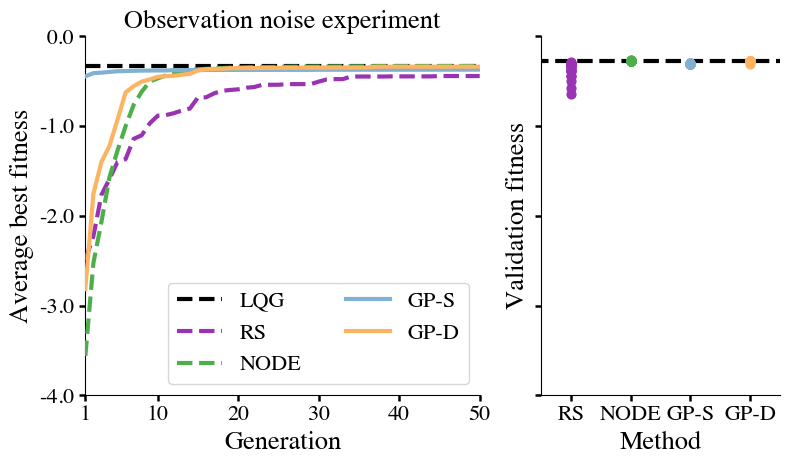

In [5]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
rs_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
node_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp1/GP-D/best_fitness_{i}.npy'))
    rs_fitness = rs_fitness.at[i].set(np.load(f'../results/Exp1/RS/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp1/GP-S/best_fitness_{i}.npy'))
    node_fitness = node_fitness.at[i].set(np.load(f'../results/Exp1/NODE/best_fitness_{i}.npy'))

LQG_fitness = np.load(f'../results/Exp1/LQG.npy')

env = HarmonicOscillator(0.05, 0.3, 2)  # Use default parameters for now

operator_list = [
    ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
    ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
    ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
    ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
]

T = 30
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Constant")
dt0 = 0.02
max_steps = 2000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', zorder=2, linewidth=3.0)
plot(-rs_fitness, n_gen, label="RS", color=color_dict["RS"], axis = a0, style='dashed')
plot(-node_fitness, n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 1, data, operator_list, dt0, max_steps)
# validate_seeds(env, "RS", 1, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 1, data, operator_list, dt0, max_steps)
# validate_nde(env, 1, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp1/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp1/GP-S_val_fitness.npy', allow_pickle=True)
NODE_val_fitness = np.load(f'../validation_results/Exp1/NODE_val_fitness.npy')
rs_val_fitness = np.load(f'../validation_results/Exp1/RS_val_fitness.npy')

for i in range(20):
    a1.scatter("RS", -rs_val_fitness[i], color=color_dict["RS"], s=40, zorder=1)
    a1.scatter("NODE", -NODE_val_fitness[i], color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["GP-D"], s=40, zorder=1)
_lqg = LQG(env, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)
a1.hlines(-_lqg(data)[-1], -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)

a0.legend(loc = 'lower right', fontsize=16, ncol=2)
a0.set(xlim=(1,50), ylim=(-4, 0))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([0.0, -1.0, -2.0, -3.0, -4.0])
a0.set_yticklabels([0.0, -1.0, -2.0, -3.0, -4.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Observation noise experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)
a1.set(xlim=(-0.5,3.5))

f.tight_layout()
plt.show()

## Experiment 2

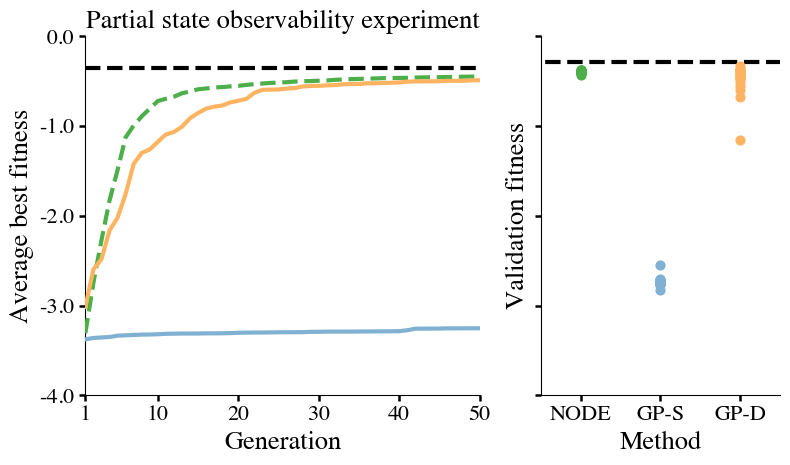

In [6]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
node_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp2/GP-D/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp2/GP-S/best_fitness_{i}.npy'))
    node_fitness = node_fitness.at[i].set(np.load(f'../results/Exp2/NODE/best_fitness_{i}.npy'))

LQG_fitness = np.load(f'../results/Exp2/LQG.npy')

env = HarmonicOscillator(0.05, 0.3, 1)  # Use default parameters for now

operator_list = [
    ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
    ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
    ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
    ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
]

T = 30
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Constant")  
dt0 = 0.02
max_steps = 2000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-node_fitness, n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', zorder=2, linewidth=3.0)
plot(-static_fitness/(T/dt), n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness/(T/dt), n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 2, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 2, data, operator_list, dt0, max_steps)
# validate_nde(env, 2, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp2/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp2/GP-S_val_fitness.npy', allow_pickle=True)
NODE_val_fitness = np.load(f'../validation_results/Exp2/NODE_val_fitness.npy', allow_pickle=True)

for i in range(20):
    a1.scatter("NODE", -NODE_val_fitness[i], color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["GP-D"], s=40, zorder=1)
_lqg = LQG(env, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)
a1.hlines(-_lqg(data)[-1], -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)

a0.tick_params(width=1.8, length=4.0, which='both')
a0.set(xlim=(1,50), ylim=(-4, 0))
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([0.0, -1.0, -2.0, -3.0, -4.0])
a0.set_yticklabels([0.0, -1.0, -2.0, -3.0, -4.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Partial state observability experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.set(xlim=(-0.5,2.5))
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 3

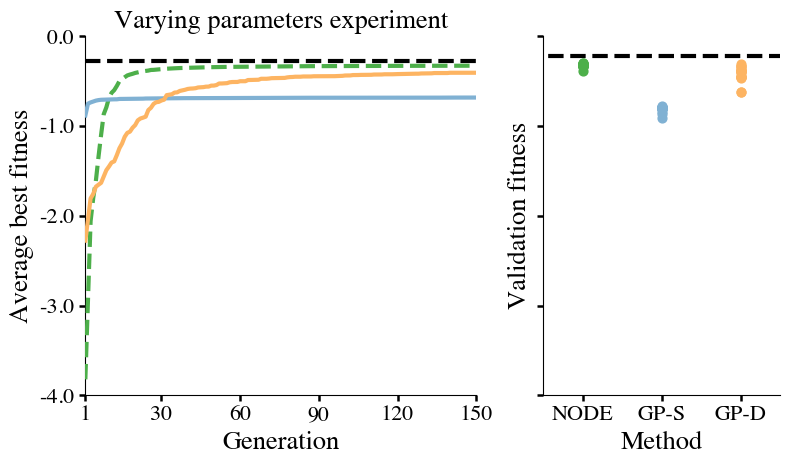

In [7]:
n_gen = 150
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
node_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp3/GP-D/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp3/GP-S/best_fitness_{i}.npy'))
    node_fitness = node_fitness.at[i].set(np.load(f'../results/Exp3/NODE/best_fitness_{i}.npy'))

LQG_fitness = np.load(f'../results/Exp3/LQG.npy')

env = HarmonicOscillator(0.05, 0.3, 2)  # Use default parameters for now

operator_list = [
    ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
    ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
    ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
    ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
]

T = 30
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Different")  
dt0 = 0.02
max_steps = 2000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-node_fitness, n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness/(T/dt), n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')
a0.hlines(-jnp.mean(LQG_fitness), 1, n_gen, label="LQG", color="black", linestyle='dashed', zorder=2, linewidth=3.0)

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 3, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 3, data, operator_list, dt0, max_steps)
# validate_nde(env, 3, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp3/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp3/GP-S_val_fitness.npy', allow_pickle=True)
node_val_fitness = np.load(f'../validation_results/Exp3/NODE_val_fitness.npy', allow_pickle=True)

for i in range(20):
    a1.scatter("NODE", -node_val_fitness[i], color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["GP-D"], s=40, zorder=1)
_lqg = LQG(env, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)
a1.hlines(-_lqg(data)[-1], -1, 4, label="LQG", color="black", linestyle='dashed', linewidth=3.0, zorder=0)

a0.set(xlim=(1,50), ylim=(-4, 0))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks([1,30,60, 90,120,150])
a0.set_xticklabels([1,30,60, 90,120,150], fontsize=16)
a0.set_yticks([0.0, -1.0, -2.0, -3.0, -4.0])
a0.set_yticklabels([0.0, -1.0, -2.0, -3.0, -4.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Varying parameters experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.set(xlim=(-0.5,2.5))
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

## Experiment 4

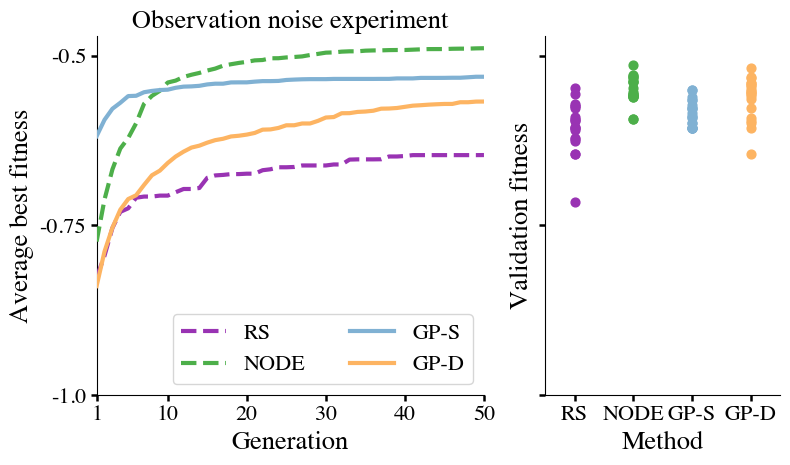

In [8]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
rs_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp4/GP-D/best_fitness_{i}.npy'))
    rs_fitness = rs_fitness.at[i].set(np.load(f'../results/Exp4/RS/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp4/GP-S/best_fitness_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/Exp4/NODE/best_fitness_{i}.npy'))

env = Acrobot(0.05, 0.3, 4)  # Use default parameters for now

operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ("sin", lambda x: jnp.sin(x), 1, 0.1),
            ("cos", lambda x: jnp.cos(x), 1, 0.1),
        ]

T = 50
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Constant")  
dt0 = 0.02
max_steps = 3000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-rs_fitness/(T/dt), n_gen, label="RS", color=color_dict["RS"], axis = a0, style='dashed')
plot(-nde_fitness/(T/dt), n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness/(T/dt)/(T/dt), n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness/(T/dt)/(T/dt), n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 4, data, operator_list, dt0, max_steps)
# validate_seeds(env, "RS", 4, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 4, data, operator_list, dt0, max_steps)
# validate_nde(env, 4, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp4/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp4/GP-S_val_fitness.npy', allow_pickle=True)
rs_val_fitness = np.load(f'../validation_results/Exp4/RS_val_fitness.npy', allow_pickle=True)
node_val_fitness = np.load(f'../validation_results/Exp4/NODE_val_fitness.npy', allow_pickle=True)

for i in range(20):
    a1.scatter("RS", -rs_val_fitness[i]/(T/dt), color=color_dict["RS"], s=40, zorder=1)
    a1.scatter("NODE", -node_val_fitness[i]/(T/dt), color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i]/(T/dt), color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i]/(T/dt), color=color_dict["GP-D"], s=40, zorder=1)

a0.legend(loc = 'lower right', fontsize=16, ncol=2)
a0.set(xlim=(1,50))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-0.5,-0.75,-1.0])
a0.set_yticklabels([-0.5,-0.75,-1.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Observation noise experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)
a1.set(xlim=(-0.5,3.5))

f.tight_layout()
plt.show()

## Experiment 5

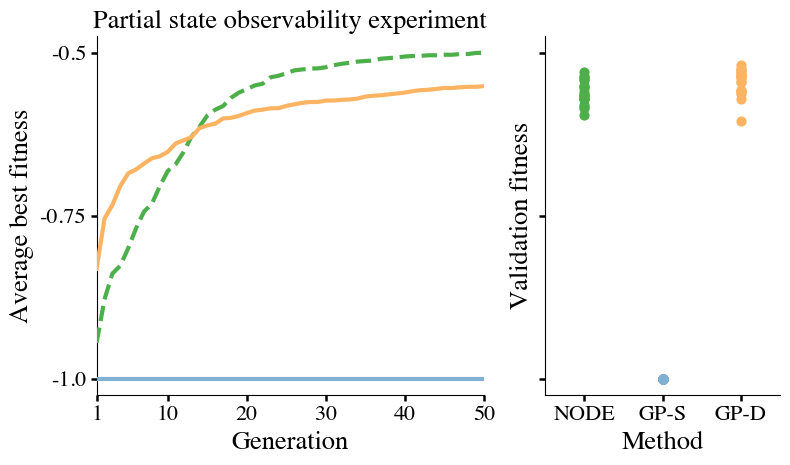

In [9]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp5/GP-D/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp5/GP-S/best_fitness_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/Exp5/NODE/best_fitness_{i}.npy'))

env = Acrobot(0.05, 0.3, 2)  # Use default parameters for now

operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ("sin", lambda x: jnp.sin(x), 1, 0.1),
            ("cos", lambda x: jnp.cos(x), 1, 0.1),
        ]

T = 50
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Constant")  
dt0 = 0.02
max_steps = 3000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-nde_fitness/(T/dt), n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness/(T/dt)/(T/dt), n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness/(T/dt)/(T/dt), n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 5, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 5, data, operator_list, dt0, max_steps)
# validate_nde(env, 5, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp5/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp5/GP-S_val_fitness.npy', allow_pickle=True)
node_val_fitness = np.load(f'../validation_results/Exp5/NODE_val_fitness.npy', allow_pickle=True)

for i in range(20):
    a1.scatter("NODE", -node_val_fitness[i]/(T/dt), color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i]/(T/dt), color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i]/(T/dt), color=color_dict["GP-D"], s=40, zorder=1)

a0.set(xlim=(1,50))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-0.5,-0.75,-1.0])
a0.set_yticklabels([-0.5,-0.75,-1.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Partial state observability experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)
a1.set(xlim=(-0.5,2.5))

f.tight_layout()
plt.show()

## Experiment 6

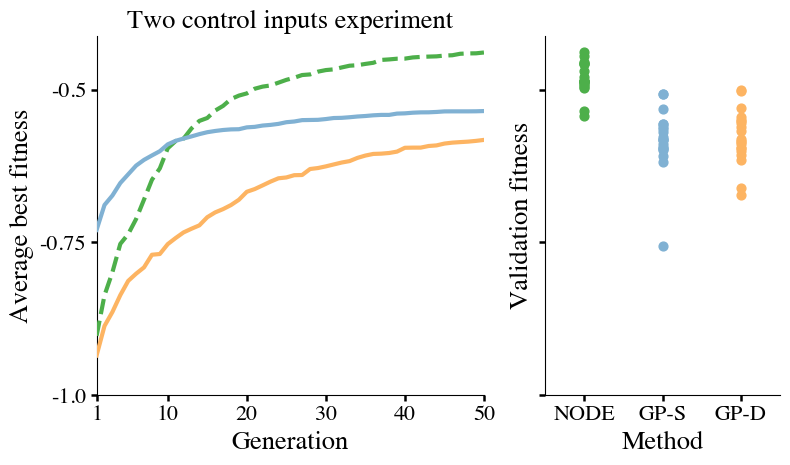

In [10]:
n_gen = 50
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp6/GP-D/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp6/GP-S/best_fitness_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/Exp6/NODE/best_fitness_{i}.npy'))

env = Acrobot2(0.05, 0.3, 4)  # Use default parameters for now

operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ("sin", lambda x: jnp.sin(x), 1, 0.1),
            ("cos", lambda x: jnp.cos(x), 1, 0.1),
        ]

T = 50
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Constant")  
dt0 = 0.02
max_steps = 3000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-nde_fitness/(T/dt), n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness/(T/dt)/(T/dt), n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness/(T/dt)/(T/dt), n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 6, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 6, data, operator_list, dt0, max_steps)
# validate_nde(env, 6, data, dt0, max_steps, 5)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp6/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp6/GP-S_val_fitness.npy', allow_pickle=True)
node_val_fitness = np.load(f'../validation_results/Exp6/NODE_val_fitness.npy', allow_pickle=True)

for i in range(20):
    a1.scatter("NODE", -node_val_fitness[i]/(T/dt), color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i]/(T/dt), color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i]/(T/dt), color=color_dict["GP-D"], s=40, zorder=1)

a0.set(xlim=(1,50))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_xticks([1,10,20,30,40,50])
a0.set_xticklabels([1,10,20,30,40,50], fontsize=16)
a0.set_yticks([-0.5,-0.75,-1.0])
a0.set_yticklabels([-0.5,-0.75,-1.0], fontsize=16)
a0.tick_params(axis='y', labelsize=16)
a0.set_title("Two control inputs experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)
a1.set(xlim=(-0.5,2.5))

f.tight_layout()
plt.show()

## Experiment 7

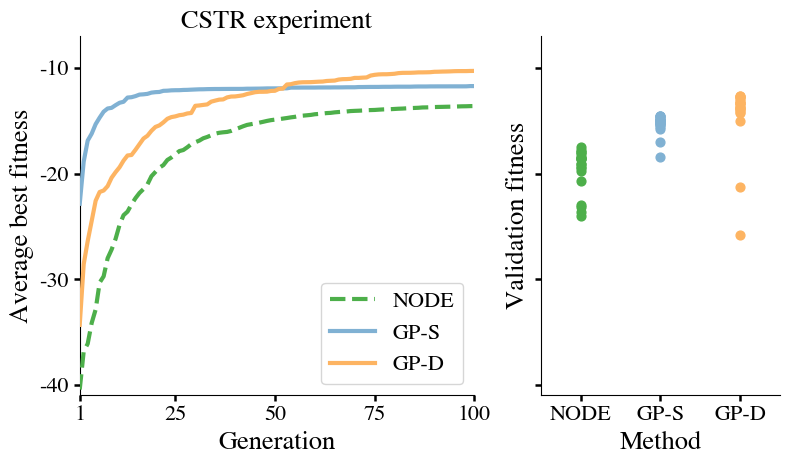

In [11]:
n_gen = 100
dynamic_fitness = jnp.zeros((20,n_gen))
static_fitness = jnp.zeros((20,n_gen))
nde_fitness = jnp.zeros((20,n_gen))

for i in range(20):
    dynamic_fitness = dynamic_fitness.at[i].set(np.load(f'../results/Exp7/GP-D/best_fitness_{i}.npy'))
    static_fitness = static_fitness.at[i].set(np.load(f'../results/Exp7/GP-S/best_fitness_{i}.npy'))
    nde_fitness = nde_fitness.at[i].set(np.load(f'../results/Exp7/NODE/best_fitness_{i}.npy'))

env = StirredTankReactor(0.5, 0.5, 2)  # Use default parameters for now

operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ("exp", lambda x: jnp.exp(jnp.clip(x, -10, 10)), 1, 0.1),
            ("log", lambda x: jnp.log(jnp.abs(x) + 1e-8), 1, 0.1),
        ]

T = 30
dt = 0.2
data = get_data(val_key, env, 32, dt, T, "Different")
dt0 = 0.001
max_steps = 40000

f, (a0, a1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3.3, 2]}, figsize=(8,4.75), sharey=True)

plot(-nde_fitness, n_gen, label="NODE", color=color_dict["NODE"], axis = a0, style='dashed')
plot(-static_fitness, n_gen, label="GP-S", color=color_dict["GP-S"], axis = a0, style='solid')
plot(-dynamic_fitness, n_gen, label="GP-D", color=color_dict["GP-D"], axis = a0, style='solid')

a0.spines[['right', 'top']].set_visible(False)

# validate_seeds(env, "GP-D", 7, data, operator_list, dt0, max_steps)
# validate_seeds(env, "GP-S", 7, data, operator_list, dt0, max_steps)
# validate_nde(env, 7, data, dt0, max_steps, 10)

#Load the validation fitnesses
dynamic_val_fitness = np.load(f'../validation_results/Exp7/GP-D_val_fitness.npy', allow_pickle=True)
static_val_fitness = np.load(f'../validation_results/Exp7/GP-S_val_fitness.npy', allow_pickle=True)
node_val_fitness = np.load(f'../validation_results/Exp7/NODE_val_fitness.npy')

for i in range(20):
    a1.scatter("NODE", -node_val_fitness[i], color=color_dict["NODE"], s=40, zorder=1)
    a1.scatter("GP-S", -static_val_fitness[i], color=color_dict["GP-S"], s=40, zorder=1)
    a1.scatter("GP-D", -dynamic_val_fitness[i], color=color_dict["GP-D"], s=40, zorder=1)

a0.legend(loc = 'lower right', fontsize=16, ncol=1)
a0.set(xlim=(1,100), ylim=(-41, -7))
a0.set_xticks([1,25,50,75,100])
a0.set_xticklabels([1,25,50,75,100], fontsize=16)
a0.tick_params(width=1.8, length=4.0, which='both')
a0.set_yticks([-10, -20, -30, -40])
a0.set_yticklabels([-10, -20, -30, -40], fontsize=16)
a0.set_title("CSTR experiment", fontsize=19)
a0.set_xlabel("Generation", fontsize=19)
a0.set_ylabel("Average best fitness", fontsize=19)

a1.set_ylabel("Validation fitness", fontsize=19)
a1.set_xlabel("Method", fontsize=19)
a1.set(xlim=(-0.5,2.5))
a1.tick_params(axis='x', labelsize=16, labelrotation=0)
a1.tick_params(width=1.8, length=4.0, which='both')
a1.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

# Lag experiment

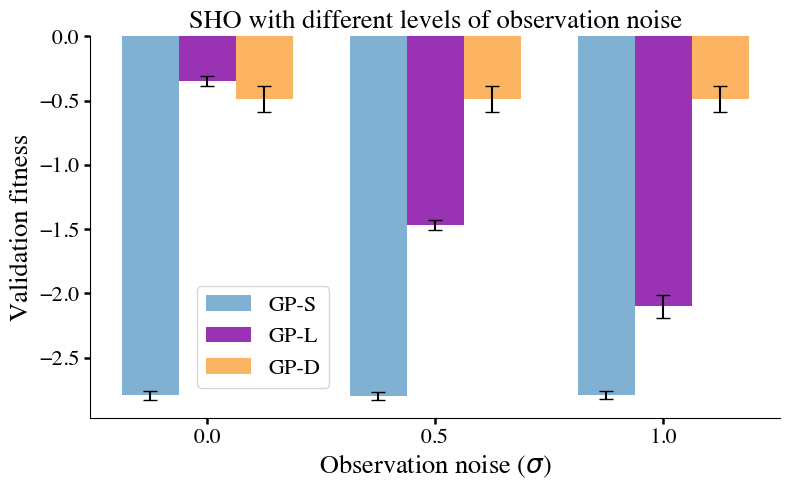

In [12]:
# Prepare data for barplot
noise_levels = ["0.0", "0.5", "1.0"]
methods = ["GP-S", "GP-L", "GP-D"]

# for i in [0.0, 0.5, 1.0]:
#     validate_lag_seeds(env, "GP-D", i, dt0, max_steps)
#     validate_lag_seeds(env, "GP-S", i, dt0, max_steps)
#     validate_lag_seeds(env, "GP-L", i, dt0, max_steps)

dynamic00_val_fitness = np.load(f'../validation_results/LagExp/GP-D_0.0_val_fitness.npy', allow_pickle=True)
dynamic05_val_fitness = np.load(f'../validation_results/LagExp/GP-D_0.0_val_fitness.npy', allow_pickle=True)
dynamic10_val_fitness = np.load(f'../validation_results/LagExp/GP-D_0.0_val_fitness.npy', allow_pickle=True)

lag00_val_fitness = np.load(f'../validation_results/LagExp/GP-L_0.0_val_fitness.npy', allow_pickle=True)
lag05_val_fitness = np.load(f'../validation_results/LagExp/GP-L_0.5_val_fitness.npy', allow_pickle=True)
lag10_val_fitness = np.load(f'../validation_results/LagExp/GP-L_1.0_val_fitness.npy', allow_pickle=True)

static00_val_fitness = np.load(f'../validation_results/LagExp/GP-S_0.0_val_fitness.npy', allow_pickle=True)
static05_val_fitness = np.load(f'../validation_results/LagExp/GP-S_0.5_val_fitness.npy', allow_pickle=True)
static10_val_fitness = np.load(f'../validation_results/LagExp/GP-S_1.0_val_fitness.npy', allow_pickle=True)

# Organize validation fitnesses by noise level
fitness_data = {
    "0.0": {"GP-S": static00_val_fitness, "GP-L": lag00_val_fitness, "GP-D": dynamic00_val_fitness},
    "0.5": {"GP-S": static05_val_fitness, "GP-L": lag05_val_fitness, "GP-D": dynamic05_val_fitness},
    "1.0": {"GP-S": static10_val_fitness, "GP-L": lag10_val_fitness, "GP-D": dynamic10_val_fitness},
}

# Calculate means and stds
means_by_noise = {noise: {} for noise in noise_levels}
stds_by_noise = {noise: {} for noise in noise_levels}

for noise in noise_levels:
    for method in methods:
        means_by_noise[noise][method] = np.mean(-fitness_data[noise][method])
        stds_by_noise[noise][method] = np.std(-fitness_data[noise][method])

# Create barplot
f, a0 = plt.subplots(figsize=(8, 5))

x = np.arange(len(noise_levels))
width = 0.25

for i, method in enumerate(methods):
    means = [means_by_noise[noise][method] for noise in noise_levels]
    stds = [stds_by_noise[noise][method] for noise in noise_levels]
    a0.bar(x + i*width, means, width, label=method, color=color_dict[method], 
           yerr=stds, capsize=5)

a0.set_xlabel("Observation noise ($\sigma$)", fontsize=19)
a0.set_ylabel("Validation fitness", fontsize=19)
a0.set_title("SHO with different levels of observation noise", fontsize=19)
a0.set_xticks(x + width)
a0.set_xticklabels(noise_levels)
a0.legend(loc='lower left', fontsize=16, bbox_to_anchor=(0.139, 0.05))
a0.tick_params(width=1.8, length=4.0, which='both')
a0.tick_params(axis='both', labelsize=16)
a0.spines[['right', 'top']].set_visible(False)

f.tight_layout()
plt.show()

# Time analysis

excess data in 'kern' subtable: 6 bytes
fdsc NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


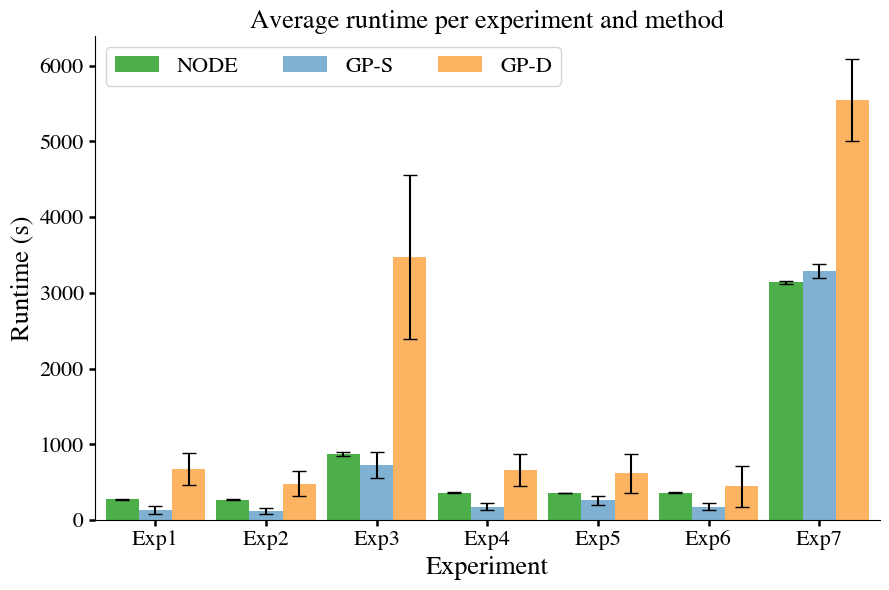

In [ ]:
# Collect runtime data for all experiments and methods
experiments = ['Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5', 'Exp6', 'Exp7']
methods = ['NODE', 'GP-S', 'GP-D']

runtime_data = {}

for exp in experiments:
    runtime_data[exp] = {}
    for method in methods:
        runtimes = []
        for i in range(20):
            runtimes.append(np.load(f'../results/{exp}/{method}/time_{i}.npy'))
        runtime_data[exp][method] = runtimes

# Calculate mean and std for each experiment and method
means = {method: [] for method in methods}
stds = {method: [] for method in methods}

for exp in experiments:
    for method in methods:
        if len(runtime_data[exp][method]) > 0:
            means[method].append(np.mean(runtime_data[exp][method]))
            stds[method].append(np.std(runtime_data[exp][method]))
        else:
            means[method].append(0)
            stds[method].append(0)

# Create barplot
fig, ax = plt.subplots(figsize=(9, 6))
x = np.arange(len(experiments))
width = 0.3

for i, method in enumerate(methods):
    ax.bar(x + i*width, means[method], width, label=method, 
           color=color_dict[method], 
           yerr=stds[method], capsize=5)

ax.set_xlabel('Experiment', fontsize=19)
ax.set_ylabel('Runtime (s)', fontsize=19)
ax.set_title('Average runtime per experiment and method', fontsize=19)
ax.set_xticks(x + width)
ax.set_xticklabels(experiments)
ax.set(xlim=(-.25,6.85))
ax.legend(fontsize=16, ncol=3)
ax.tick_params(axis='both', labelsize=16)
ax.tick_params(width=1.8, length=4.0, which='both')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.show()

## CSTR Simulations

In [14]:
env = StirredTankReactor(0.5, 0.5, n_targets=1, n_obs=2)
plot_key = jr.PRNGKey(100)

T = 40
dt = 0.2
data = get_data(plot_key, env, 32, dt, T, "Different")

operator_list = [
        ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
        ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
        ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
        ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
        ("exp", lambda x: jnp.exp(jnp.clip(x, -10, 10)), 1, 0.1),
        ("log", lambda x: jnp.log(jnp.abs(x) + 1e-8), 1, 0.1),
    ]

x0s, ts, targets, keys1, keys2, params = data
variable_list = [["y" + str(i) for i in range(env.n_obs)] + ["a" + str(i) for i in range(2)] + ["u" + str(i) for i in range(env.n_control_inputs)], ["a" + str(i) for i in range(2)]]
if env.n_targets > 0:
    for var_list in variable_list:
        var_list.append("tar")

# Define layer sizes (output size = control dimension)
layer_sizes = jnp.array([2, env.n_control_inputs])
dt0 = 0.001
max_steps = 60000

fitness_function = DynamicEvaluator(env, 2, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)

strategy = GeneticProgramming(
    fitness_function=fitness_function,
    num_generations=1,
    population_size=2,
    operator_list=operator_list,
    variable_list=variable_list,
    layer_sizes=layer_sizes,
)
# for i in range(20):
#     fitness, model = validate(np.load(f'../results/Exp7/GP-D/best_solutions_{i}.npy'), strategy, data, "GP-D")
    # print(i, fitness, strategy.expression_to_string(model))

fitness, model = validate(np.load(f'../results/Exp7/GP-D/best_solutions_{3}.npy'), strategy, data, "GP-D")

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].


Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
[(tar + y1)*(-a0 - tar + u0 + y1), -2.65, a0 - exp(exp(1.2*a0/tar))] [37.614147]


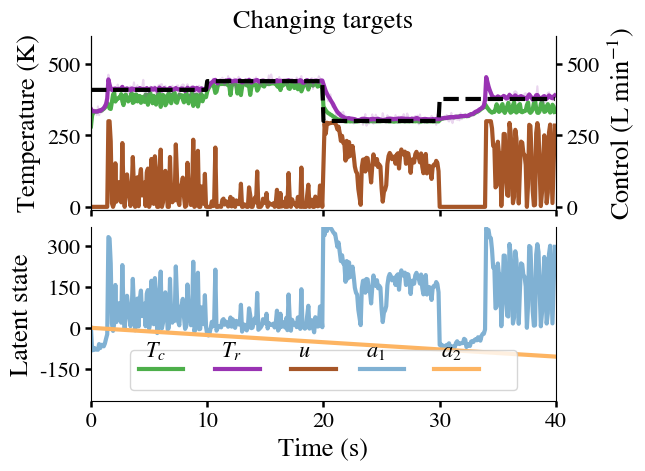

In [15]:
def plot_reactor(env, data, model, title, batch_index=0, plot_legend = False):
    operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ("exp", lambda x: jnp.exp(jnp.clip(x, -10, 10)), 1, 0.1),
            ("log", lambda x: jnp.log(jnp.abs(x) + 1e-8), 1, 0.1),
        ]
    
    plt.rcParams["mathtext.fontset"] = 'stix'
    x0s, ts, targets, keys1, keys2, params = data
    variable_list = [["y" + str(i) for i in range(env.n_obs)] + ["a" + str(i) for i in range(2)] + ["u" + str(i) for i in range(env.n_control_inputs)], ["a" + str(i) for i in range(2)]]
    if env.n_targets > 0:
        for var_list in variable_list:
            var_list.append("tar")

    # Define layer sizes (output size = control dimension)
    layer_sizes = jnp.array([2, env.n_control_inputs])
    dt0 = 0.0015
    max_steps = 60000
    
    fitness_function = DynamicEvaluator(env, 2, dt0, solver=diffrax.GeneralShARK(), max_steps = max_steps)

    strategy = GeneticProgramming(
        fitness_function=fitness_function,
        num_generations=1,
        population_size=2,
        operator_list=operator_list,
        variable_list=variable_list,
        layer_sizes=layer_sizes,
    )

    dxs, dys, dus, activities, dfitness = fitness_function.evaluate_candidate(model, data, strategy.tree_evaluator)
    print(strategy.expression_to_string(model), dfitness)

    figure, ax = plt.subplots(2, 1, figsize=(6,4.75), sharex=True, sharey=False)
    labels = ["T_c", "T_r"]
   
    moving_targets = jax.vmap(lambda tar: jnp.hstack([t*jnp.ones(int(ts.shape[0]//targets.shape[1])) for t in tar]))(targets)[batch_index]

    colormap2 = cm.Set1

    width = 3.0
    ax[1].plot(0, 0, color = colormap2(0.3), label = f"${labels[0]}$", linewidth = width)
    ax[1].plot(0, 0, color = (0.6, 0.2, 0.7, 1.0), label = f"${labels[1]}$", linewidth = width)

    ax[0].plot(ts, dxs[batch_index,:,0], color = colormap2(0.3), label = f"${labels[0]}$", linewidth = width)
    ax[0].plot(ts, dys[batch_index,:,0], color = colormap2(0.3), alpha = 0.2)

    ax[0].plot(ts, dxs[batch_index,:,1], color = (0.6, 0.2, 0.7, 1.0), label = f"${labels[1]}$", linewidth = width)
    ax[0].plot(ts, dys[batch_index,:,1], color = (0.6, 0.2, 0.7, 1.0), alpha = 0.2)
   
    ax[0].plot(ts, jnp.clip(dus[batch_index,:,0], 0, 300), color = colormap2(0.7), label = f"$u$", linewidth = width)
    ax[1].plot(0, 0, color = colormap2(0.7), label = f"$u$", linewidth = width)
    ax[0].plot(ts, moving_targets, linestyle='dashed', color = "black", linewidth = width)

    for j in range(activities.shape[-1]):
        ax[1].plot(ts, activities[batch_index,:,j], color = colormap(0.4+j*0.05), label = f"$a_{j+1}$", linewidth = width)

    for a in ax.ravel():
        a.set(xlim=(0,ts[-1]))
        a.tick_params(axis='y', labelsize=16)
        a.tick_params(width=1.8, length=4.0, which='both')
        a.spines[['top']].set_visible(False)

    ax[0].set_title(title, fontsize=19)
    ax[0].set(ylim=(-10,600))
    ax[1].set(ylim=(-270,370))
    ax[1].set_xticks([0,10,20,30,40])
    ax[1].set_xticklabels([0,10,20,30,40], fontsize=16)
    ax[1].tick_params(axis='x', labelsize=16)
    ax[1].set_xlabel("Time (s)", fontsize=19)

    ax[0].set_ylabel("Temperature (K)", fontsize=19)
    ax[1].set_ylabel("Latent state", fontsize=19)

    # ax[1].set_yticks([-50,0,50])
    ax[0].set_yticks([0,250,500])
    ax[0].set_yticklabels([0,250,500], fontsize=16)
    ax[1].set_yticks([-150, 0, 150, 300])
    ax[1].set_yticklabels([-150, 0, 150, 300], fontsize=16)

    ax2 = ax[0].twinx()
    ax2.set_ylabel("Control (L min$^{-1}$)", fontsize=19)

    ax2.tick_params(axis='y', labelsize=16)
    ax2.tick_params(width=1.8, length=4.0, which='both')
    ax2.spines[['top']].set_visible(False)
    ax2.set_yticks([0,250,500])
    ax2.set_yticklabels([0,250,500], fontsize=16)
    ax2.set(ylim=(-10,600))

    if plot_legend:
        legend1 = ax[1].legend(ncol=5, fontsize=16, loc='lower center', frameon=True, columnspacing=0.1, handletextpad=0.4)
        # legend1 = ax[1].legend(ncol=5, fontsize=19, bbox_to_anchor=(0.03, 0.4), frameon=True, columnspacing=0.1, handletextpad=0.4)
    
        # Update the legend font properties
        for text in legend1.get_texts():
            text.set_fontfamily('times')

        for txt in legend1.get_texts():
            txt.set_ha("center") # horizontal alignment of text item
            txt.set_x(-47) # x-position
            txt.set_y(20) # y-position

    plt.subplots_adjust(wspace=0.0, hspace=0.1)
    plt.show()

env = StirredTankReactor(0.5, 0.5, n_targets=4, n_obs=2)
plot_key = jr.PRNGKey(104)

T = 40
dt = 0.1
data = get_data(plot_key, env, 1, dt, T, "Different")

ax0 = plot_reactor(env, data, model, "Changing targets", plot_legend = True)

The legend has been placed in a correct position manually.

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
[(tar + y1)*(-a0 - tar + u0 + y1), -2.65, a0 - exp(exp(1.2*a0/tar))] [14.669678]


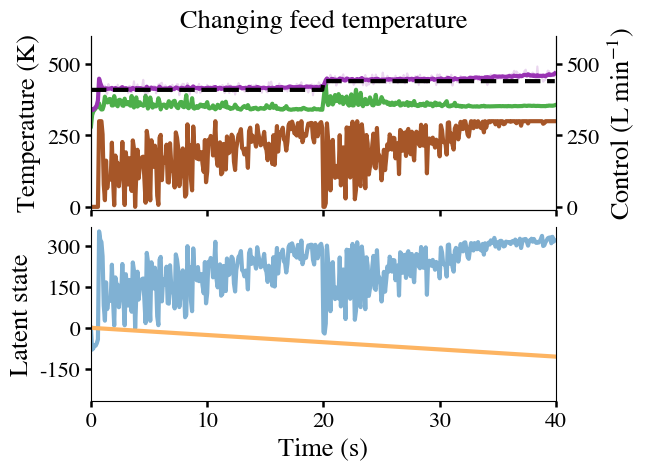

In [16]:
env = StirredTankReactor(0.5, 0.5, n_targets=2, n_obs=2)
plot_key = jr.PRNGKey(104)
reactor_data = get_data(plot_key, env, 1, dt, T, "Changing")
ax0 = plot_reactor(env, reactor_data, model, "Changing feed temperature", plot_legend = False)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
[(tar + y1)*(-a0 - tar + u0 + y1), -2.65, a0 - exp(exp(1.2*a0/tar))] [19.317493]


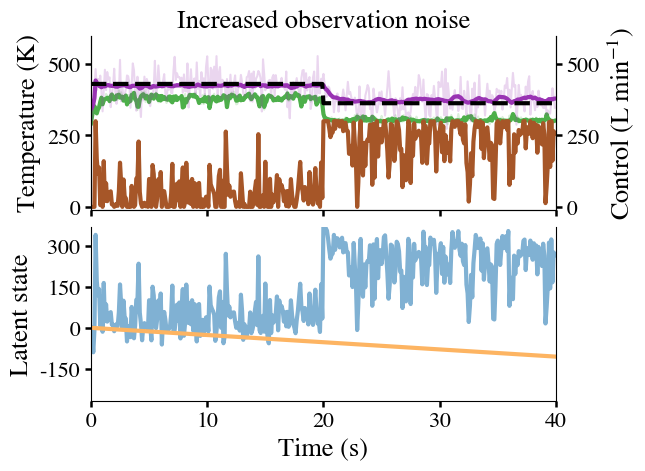

In [17]:
env = StirredTankReactor(0.5, 2.0, n_targets=2, n_obs=2)
plot_key = jr.PRNGKey(115)
reactor_data = get_data(plot_key, env, 1, dt, T, "Different")
ax0 = plot_reactor(env, reactor_data, model, "Increased observation noise", plot_legend = False)

Input data should be formatted as: ['y0', 'y1', 'a0', 'a1', 'u0', 'tar'].
[(tar + y1)*(-a0 - tar + u0 + y1), -2.65, a0 - exp(exp(1.2*a0/tar))] [55.179184]


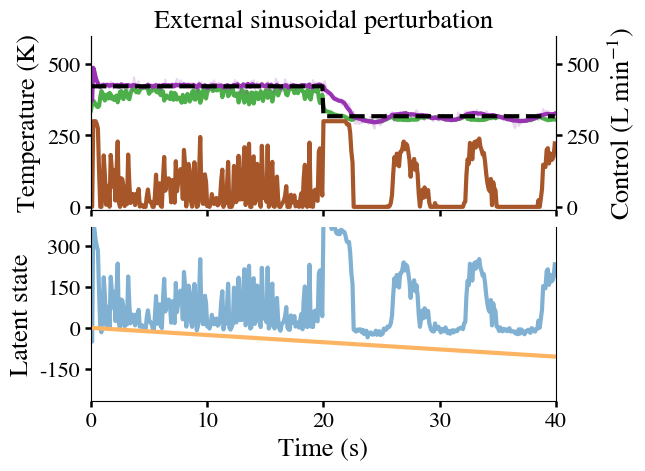

In [18]:
env = StirredTankReactor(0.5, 0.5, n_targets=2, n_obs=2, external_f=lambda t: 30*jnp.sin(t))
plot_key = jr.PRNGKey(145)
reactor_data = get_data(plot_key, env, 1, dt, T, "Different")

ax0 = plot_reactor(env, reactor_data, model, "External sinusoidal perturbation", plot_legend = False)

# Printing best solutions

In [19]:
def expression_to_string(candidate, strategy) -> str:
        """
        Maps trees in a candidate to string.

        Parameters
        ----------
        candidate : Array
            Candidate to be converted to string.

        Returns
        -------
        str
            String representation of candidate.
        """
        if strategy.num_trees == 1:
            simplified_expression = sp.parsing.sympy_parser.parse_expr(strategy.tree_to_string(candidate[0]))

            rounded_expression = simplified_expression

            return rounded_expression

        string_output = []
        for tree in candidate:
            simplified_expression = sp.parsing.sympy_parser.parse_expr(strategy.tree_to_string(tree))

            rounded_expression = simplified_expression

            string_output.append(rounded_expression)

        return string_output

In [ ]:
def print_best_solutions(method):
    args = [["HO", "Constant", 2, 0.05, 0.3, 1], ["HO", "Constant", 1, 0.05, 0.3, 1], ["HO", "Different", 2, 0.05, 0.3, 1], ["ACR", "Constant", 4, 0.05, 0.3, 1], 
            ["ACR", "Constant", 2, 0.05, 0.3, 1], ["ACR", "Constant", 4, 0.05, 0.3, 2], ["CSTR", "Different", 2, 0.5, 0.5, 1]]

    if method == "RS":
        experiments = [1,4]
        _method = "GP-D"
    else:    
        experiments = range(1,8)
        _method = method

    for i in experiments:
        env_string, param_setting, n_obs, process_noise, obs_noise, n_control = args[i-1]
        if env_string == "HO":
            env = HarmonicOscillator(process_noise, obs_noise, n_obs)  # Use default parameters for now

            operator_list = [
                ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
                ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
                ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
                ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
            ]
            dt0 = 0.02
            max_steps = 2000
            T = 30

        elif env_string == "ACR":
            if n_control == 1:
                env = Acrobot(process_noise, obs_noise, n_obs)  # Use default parameters
            else:
                env = Acrobot2(process_noise, obs_noise, n_obs)

            operator_list = [
                ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
                ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
                ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
                ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
                ("sin", lambda x: jnp.sin(x), 1, 0.1),
                ("cos", lambda x: jnp.cos(x), 1, 0.1),
            ]
            dt0 = 0.02
            max_steps = 3000
            T = 50

        elif env_string == "CSTR":
            env = StirredTankReactor(process_noise, obs_noise, n_obs)  # Use default parameters

            operator_list = [
                ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
                ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
                ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
                ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
                ("exp", lambda x: jnp.exp(jnp.clip(x, -10, 10)), 1, 0.1),
                ("log", lambda x: jnp.log(jnp.abs(x) + 1e-8), 1, 0.1),
            ]
            dt0 = 0.001
            max_steps = 40000
            T = 30
        
        data = get_data(jr.PRNGKey(100), env, 32, 0.2, T, param_setting)  
        strategy = get_strategy(env, _method, operator_list, dt0, max_steps)
        best_idx = jnp.argmin(np.load(f'../validation_results/Exp{i}/{method}_val_fitness.npy', allow_pickle=True))
        best_fitness, best_model = validate(np.load(f'../results/Exp{i}/{method}/best_solutions_{best_idx}.npy'), strategy, data, _method)

        if i in [4,5,6]:
            best_fitness = best_fitness/(T/0.2)

        print(f"Complexity ({method}): {best_fitness}, {jnp.sum(best_model[...,0]!=0)}, {expression_to_string(best_model, strategy)}")

print_best_solutions("GP-D")

In [ ]:
for i in range(1,8):
    if i in [4,5,6]:
        print(jnp.min(np.load(f'../validation_results/Exp{i}/NODE_val_fitness.npy', allow_pickle=True))/250)
    else:
        print(jnp.min(np.load(f'../validation_results/Exp{i}/NODE_val_fitness.npy', allow_pickle=True)))

In [22]:
def print_best_lag_solutions(method):
    args = ["HO", "Constant", 1, 0.05, 1]

    for obs_noise in [0.0, 0.5, 1.0]:
        env_string, param_setting, n_obs, process_noise, n_control = args
        env = HarmonicOscillator(process_noise, obs_noise, n_obs)  # Use default parameters for now

        operator_list = [
            ("+", lambda x, y: jnp.add(x, y), 2, 0.5),
            ("*", lambda x, y: jnp.multiply(x, y), 2, 0.3),
            ("-", lambda x, y: jnp.subtract(x, y), 2, 0.5),
            ("/", lambda x, y: jnp.divide(x, y), 2, 0.1),
        ]
        dt0 = 0.02
        max_steps = 2000
        T = 30
        dt = 0.2

        if method=="GP-L":
            dt = 0.02

        data = get_data(jr.PRNGKey(100), env, 32, dt, T, param_setting)
        strategy = get_strategy(env, method, operator_list, dt0, max_steps)

        best_idx = jnp.argmin(np.load(f'../validation_results/LagExp/{method}_{obs_noise}_val_fitness.npy', allow_pickle=True))
        best_fitness, best_model = validate(np.load(f'../results/LagExp/{obs_noise}/{method}/best_solutions_{best_idx}.npy'), strategy, data, method)

        print(f"Complexity ({method}): {best_fitness}, {jnp.sum(best_model[...,0]!=0)}, {expression_to_string(best_model, strategy)}")

print_best_lag_solutions("GP-L")

Input data should be formatted as: ['y0', 'y1', 'y2', 'y3', 'y4', 'tar'].
Complexity (GP-L): 0.2842511534690857, 21, tar + 9.64711080176067*y0 + 3.21570360058689*y1 - 3.21570360058689*y2 - 9.64711080176067*y3
Input data should be formatted as: ['y0', 'y1', 'y2', 'y3', 'y4', 'tar'].
Complexity (GP-L): 1.3999398946762085, 23, 0.7947341*tar + 1.2052659*y0 + 0.4105318*y1 - 0.4105318*y3 - y4
Input data should be formatted as: ['y0', 'y1', 'y2', 'y3', 'y4', 'tar'].
Complexity (GP-L): 1.9951918125152588, 21, 0.64651477229673*tar + 0.64651477229673*y0 + 0.288891660681614*y1 - 0.19967013229673*y3 - 0.44684464*y4
